In [197]:
import sys

sys.path.append('/home/lumargot/hysterectomy-coach/src/py')

In [198]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch
import pytorch_lightning as pl
from torchvision import transforms
import cv2
import imageio
import random

import monai
import math
from tqdm import tqdm

import SimpleITK as sitk
import matplotlib.pyplot as plt

from nets.segmentation import MaskRCNN
from loaders.hyst_dataset import HystDataModuleSeg, TrainTransformsSeg, EvalTransformsSeg
from matplotlib.patches import Rectangle

from nets.segmentation import MaskRCNN
from loaders.hyst_dataset import HystDataModuleSeg, TrainTransformsSeg, EvalTransformsSeg

In [199]:
# df_train = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_6_classes_train_train.csv')
# df_val = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_6_classes_train_test.csv')
df_test = pd.read_csv('/MEDUSA_STOR/jprieto/surgery_tracking/csv/dataset_6_classes_test.csv')

# mini_df = df_test[:100]
class_column = 'class'
mount_point = '/MEDUSA_STOR/jprieto/surgery_tracking/'
img_column = 'img_path'
seg_column = 'seg_path'

In [200]:
class_names = ['Background','Other', 'Laparoscopic Grasper', 'Laparoscopic Needle Driver', 'Needle', 'Robot Needle Driver', 'Robot Grasper']

In [206]:
ckpt = '/MEDUSA_STOR/jprieto/surgery_tracking/output/no_augm/epoch=5-val_loss=1.13.ckpt'

In [207]:
ttdata = HystDataModuleSeg( df_test, df_test, df_test, batch_size=1, num_workers=4, 
                            img_column=img_column,seg_column=seg_column, class_column=class_column, 
                            mount_point=mount_point,train_transform=TrainTransformsSeg(),valid_transform=EvalTransformsSeg())

ttdata.setup()

test_dl = ttdata.test_dataloader()
test_ds = ttdata.test_ds

model = MaskRCNN.load_from_checkpoint(ckpt)
    
model.eval()
model.cuda()


MaskRCNN(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): 

In [203]:
def filter_by_confidence(class_ids, scores, masks, boxes, thr):
  """
    Filter detections based on absolute and relative confidence scores. see Notion for example.
    If there are 3 masks with the same labeled, remove the one(s) with lower confidence score(s)

    Args:
        class_ids, scores, masks
        
    Returns:
        Filtered class_ids, scores, and masks
  """

  keep = scores >= thr
  
  class_ids = class_ids[keep]
  scores = scores[keep]
  boxes = boxes[keep]
  masks = masks[keep]
  
  final_keep = []
  unique_classes = np.unique(class_ids)
  
  for class_id in unique_classes:
      class_mask = class_ids == class_id
      if not np.any(class_mask):
          continue
          
      class_scores = scores[class_mask]
      max_score = np.max(class_scores)
      relative_keep = class_scores >= (max_score - (max_score * 0.15))
      
      # Get indices of detections to keep for this class
      keep_idx = np.where(class_mask)[0][relative_keep]
      final_keep.extend(keep_idx)
      
  final_keep = np.array(sorted(final_keep))
    
  return class_ids[final_keep], scores[final_keep], masks[final_keep], boxes[final_keep]

In [204]:
batch = test_ds[0]
imgs, targets = [],[]
img = batch.pop('img', None)

batch['boxes'] = ttdata.compute_bb_mask(batch['masks'], pad=0.01)


batch['boxes'] = batch['boxes'].cuda()
batch['masks'] = batch['masks'].cuda()
batch['labels'] = batch['labels'].cuda()

imgs.append(img.unsqueeze(0))
targets.append(batch)
imgs = torch.cat(imgs)

In [205]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def imshow(tensor, boxes):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(1, figsize=(10, 10))
    tensor = tensor.numpy().transpose((1, 2, 0))
    for i in range(boxes.shape[0]):
      color = ['r', 'y', 'b', 'g']
      width = boxes["boxes"][i][2] - boxes["boxes"][i][0]
      height = boxes["boxes"][i][3] - boxes["boxes"][i][1]
      rect = patches.Rectangle((boxes["boxes"][i][0], boxes["boxes"][i][1]), width, height, linewidth = 2, edgecolor = color[i%4], facecolor = 'none', alpha=0.9)
      ax.add_patch(rect)
    ax.imshow(tensor)

In [16]:
imgs.shape

torch.Size([1, 3, 480, 720])

In [ ]:
data_out = []
with torch.no_grad():
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)): 
        
        imgs = []
        img = batch.pop('img', None)

        imgs.append(img)
        imgs = torch.cat(imgs)

        outputs = model.forward(imgs.cuda(), mode='test')
        SCORE_THR = 0.4

        pred_boxes = outputs[0]['boxes'].cpu().detach().numpy()
        pred_masks = outputs[0]['masks'].cpu().detach().numpy()
        pred_labels = outputs[0]['labels'].cpu().detach().numpy()
        pred_scores = outputs[0]['scores'].cpu().detach().numpy()

        gt_masks = batch['masks'][0]
        gt_boxes = ttdata.compute_bb_mask(gt_masks, pad=0.01).numpy()
        gt_labels = batch['labels'][0].cpu().detach().numpy()


        if (pred_scores >=SCORE_THR).any():
            refined_labels, refined_scores, refined_masks, refined_boxes = filter_by_confidence(pred_labels, 
                                                                                                pred_scores, 
                                                                                                pred_masks, 
                                                                                                pred_boxes, 
                                                                                                thr=SCORE_THR)
            refined_masks[refined_masks>0.3] = 1

            data_out.append({'pred_masks': refined_masks,
                             'pred_boxes': refined_boxes,
                             'pred_labels': refined_labels,
                             'pred_scores': refined_scores,
                             'gt_masks': gt_masks.numpy(),
                             'gt_boxes': gt_boxes,
                             'gt_labels': gt_labels,
                             })

        #     # from here :
        #     # 1. save bounding boxes , masks, scores and labels in pickle or json ?
        # dump everything is picke for now, find a best way later 
        #     # 2. save in csv

        #     # 3. Build multi - masks
        #     # 4. save these masks

 12%|█▏        | 960/7953 [15:37<2:41:28,  1.39s/it]

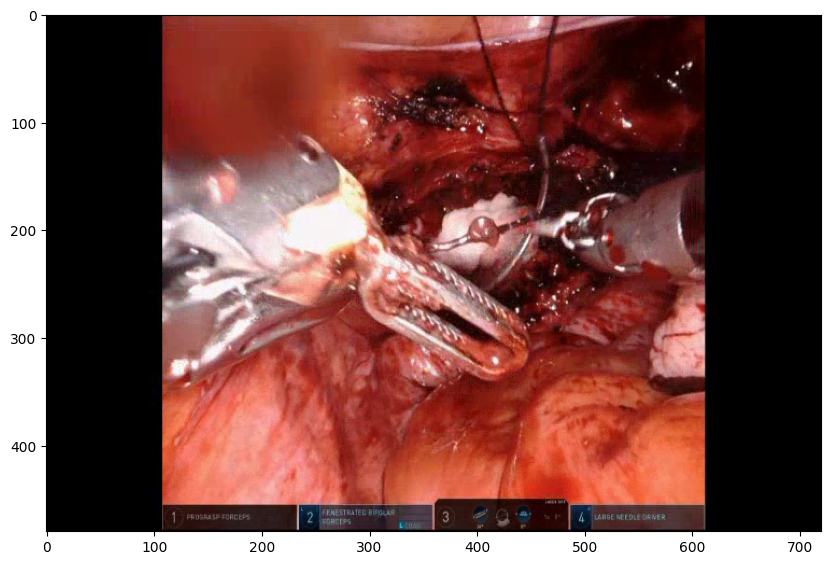

In [196]:
plt.figure(figsize=(10,10))
plt.imshow(imgs[0].permute(1,2,0))

Needle None
Robot Needle Driver None
Robot Grasper None
Other None


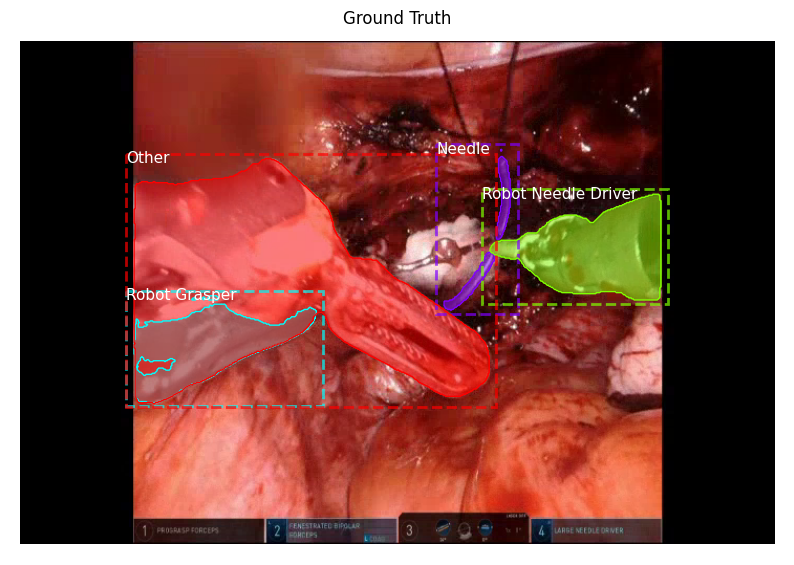

In [188]:
## ground truth 

display_instances(image=255*imgs[0].permute(1,2,0).numpy(), 
                  boxes=gt_boxes[:, [1, 0, 3, 2]], 
                  masks=gt_masks.permute(1,2,0).numpy(),
                  class_ids=gt_labels, 
                  class_names=class_names,
                  figsize = (10,10),
                  title='Ground Truth',
                  show_mask = True)

In [189]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display



############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            print(label, score)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()



# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")


def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,
                  overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictions and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)),
               ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),
               [class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh
                 else "black" if overlaps[i, j] > 0
                 else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),
                 horizontalalignment="center", verticalalignment="center",
                 fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None,
               masks=None, captions=None, visibilities=None,
               title="", ax=None):
    """Draw bounding boxes and segmentation masks with different
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominent each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))


def display_table(table):
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))


def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = model.get_trainable_layers()
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)

In [190]:
# # imshow(imgs.cpu().detach(), outputs)
# fig, ax = plt.subplots(1, figsize=(10, 10))
# tensor = imgs[0].cpu().detach().numpy().transpose((1, 2, 0))
# for i in range(refined_boxes.shape[0]):
#     color = ['r', 'y', 'b', 'g']
#     width = refined_boxes[i][2] - refined_boxes[i][0]
#     height = refined_boxes[i][3] - refined_boxes[i][1]
#     rect = patches.Rectangle((refined_boxes[i][0], refined_boxes[i][1]), width, height, linewidth = 2, edgecolor = color[i%4], facecolor = 'none', alpha=0.9)
#     ax.add_patch(rect)
#     ax.imshow(tensor)

Other 0.850438
Robot Needle Driver 0.5604509
Robot Needle Driver 0.534831


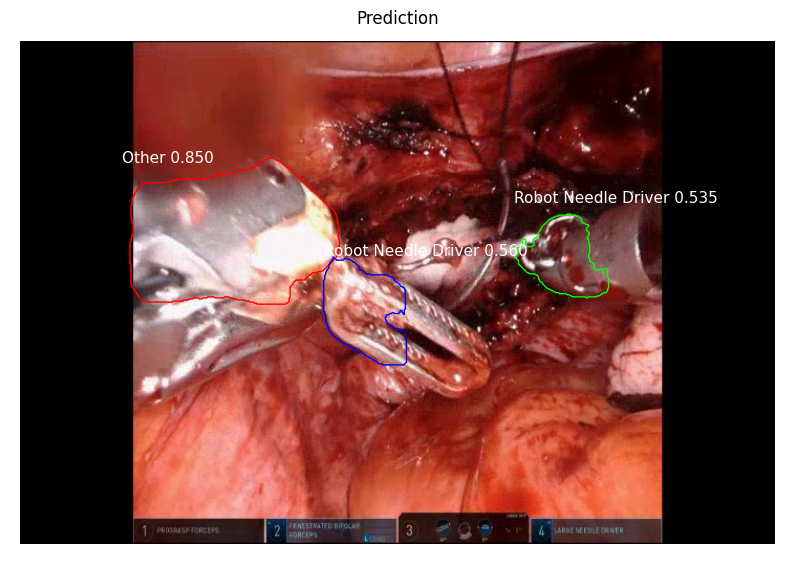

In [192]:

display_instances(image=255*imgs[0].permute(1,2,0).numpy(), 
                  boxes=refined_boxes[:, [1, 0, 3, 2]], 
                  masks=refined_masks[:,0,:,:].transpose(1,2,0), 
                  class_ids=refined_labels, 
                  class_names=class_names, scores=refined_scores, 
                  show_mask = False, show_bbox=False,
                  title='Prediction',
                  figsize = (10,10),)

In [ ]:
img